In [1]:
import sys 
sys.path.append('..')
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import torch as ch
from torch import Tensor
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions import Uniform
from torch.utils.data import DataLoader
from delphi.stats.truncated_regression import truncated_regression
from delphi.utils.datasets import TruncatedRegressionDataset
from delphi.oracle import Left, Interval
import datetime

In [2]:
STORE_PATH = '/home/pstefanou/Uniform'
STORE_TABLE_NAME = 'uniform'

store = Store(STORE_PATH)

store.add_table(STORE_TABLE_NAME, { 
    'known_param_mse': float,
    'unknown_param_mse': float,
    'unknown_var_mse': float,
    'ols_param_mse': float,
    'alpha': float, 
    'var': float, 
})

Logging in: /home/pstefanou/Uniform/cbfee529-9314-4040-8360-2e97f14a46ea


## Default Experiment Parameters

In [ ]:
# regression parameters
NUM_SAMPLES, DIMS = 10000, 10
PREDICATE = Left(Tensor([1.0]))

# procedure hyperparameters
args = Parameters({ 
    'alpha': Tensor([y_trunc.size(0)/NUM_SAMPLES]), 
    'phi': phi, 
    'epochs': 25,
    'num_workers': 0, 
    'batch_size': 10,
    'bias': True,
    'num_samples': 100,
    'clamp': True, 
    'radius': 5.0, 
    'var_lr': 1e-2,
    'var': emp_var,
    'lr': 1e-1,
    'shuffle': True
})

In [4]:
# perform each experiment a total of 10 times
for iter_ in range(10):        
    for var in range(1, 20):
        # generate random uniform weights
        W = Uniform(-1, 1).sample(ch.Size([DIMS, 1]))
        W0 = Uniform(-1, 1).sample(ch.Size([1, 1]))

        # generate data
        X = MultivariateNormal(ch.zeros(DIMS), ch.eye(DIMS)/DIMS).sample(ch.Size([NUM_SAMPLES]))
        y = X.mm(W) + W0 + Normal(ch.zeros(1), ch.sqrt(Tensor([var]))).sample(ch.Size([NUM_SAMPLES]))
        # truncate
        indices = PREDICATE(y).nonzero(as_tuple=False).flatten()
        y_trunc, x_trunc = y[indices], X[indices]

        # empirical linear regression
        reg = LinearRegression() 
        reg.fit(x_trunc, y_trunc)
        emp_var = ch.var(ch.from_numpy(reg.predict(x_trunc)) - y_trunc, dim=0).unsqueeze(0)
        
        # calculate survival probability
        args.__setattr__('alpha', Tensor([y_trunc.size(0)/NUM_SAMPLES]))

        # truncated linear regression with known noise variance
        data = TruncatedRegressionDataset(x_trunc, y_trunc, bias=args.bias, unknown=False)
        S = DataLoader(data, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=args.shuffle)
        trunc_reg = truncated_regression(phi=args.phi, alpha=args.alpha, epochs=args.epochs, lr=args.lr, num_samples=args.num_samples, var=args.var)
        results = trunc_reg.fit(S)
        w_, w0_ = results.weight.detach().cpu(), results.bias.detach().cpu()

        # truncated linear regression with unknown noise variance
        data = TruncatedRegressionDataset(x_trunc, y_trunc, bias=args.bias, unknown=True)
        S = DataLoader(data, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=args.shuffle)
        trunc_reg = truncated_regression(phi=args.phi, alpha=args.alpha, epochs=args.epochs, var_lr=args.var_lr, lr=args.lr, num_samples=args.num_samples)
        results = trunc_reg.fit(S)
        var_ = results.lambda_.inverse().detach()
        w, w0 = (results.v.detach()*var_).cpu(), (results.bias.detach()*var_).cpu()

        # parameter estimates 
        real_params = ch.cat([W, W0])
        ols_params = ch.cat([data.w, data.w0.unsqueeze(0)])
        unknown_params = ch.cat([w, w0])
        known_params = ch.cat([w_.t(), w0_.unsqueeze(0)])
        
        # metrics
        unknown_param_mse = mean_squared_error(unknown_params, real_params)
        unknown_var_mse = mean_squared_error(var_, Tensor([var]))
        ols_param_mse = mean_squared_error(ols_params, real_params)
        known_param_mse = mean_squared_error(known_params, real_params)

        store[STORE_TABLE_NAME].append_row({ 
            'known_param_mse': known_param_mse,
            'unknown_param_mse': unknown_param_mse,
            'unknown_var_mse': unknown_var_mse,
            'ols_param_mse': ols_param_mse,
            'alpha': float(args.alpha.flatten()),
            'var': float(var), 
        })

# close current store
store.close()

# Results

In [15]:
reader = CollectionReader(STORE_PATH)
results = reader.df(STORE_TABLE_NAME)
results.head()
reader.close() # close reader

100%|██████████| 13/13 [00:00<00:00, 191.87it/s]

,known_param_mse,unknown_param_mse,ols_param_mse,alpha,var,exp_id
0,0.229495,0.229495,0.229495,0.3954,1.0,6c5a334f-b3f1-4d57-81f2-4d59dd51ef80
1,0.168892,0.167581,0.168892,0.7402,2.0,6c5a334f-b3f1-4d57-81f2-4d59dd51ef80
2,0.650567,0.676718,0.678642,0.0641,3.0,6c5a334f-b3f1-4d57-81f2-4d59dd51ef80
3,0.895550,0.874560,0.895550,0.2629,4.0,6c5a334f-b3f1-4d57-81f2-4d59dd51ef80
4,0.357972,0.403891,0.385633,0.4885,5.0,6c5a334f-b3f1-4d57-81f2-4d59dd51ef80


In [6]:
known, unknown, ols = results[['known_param_mse', 'var']], results[['unknown_param_mse', 'var']], results[['ols_param_mse', 'var']]

# All Results

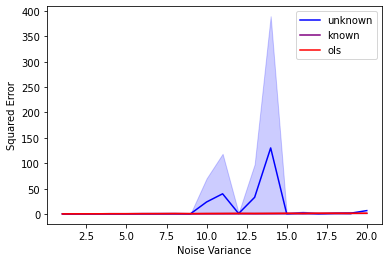

In [14]:
# plot results for regression parameter MSE
sns.lineplot(data=unknown, x='var', y='unknown_param_mse', label='unknown', color='blue')
sns.lineplot(data=known, x='var', y='known_param_mse', label='known', color='purple')
ax = sns.lineplot(data=ols, x='var', y='ols_param_mse', label='ols', color='red')
ax.set(xlabel='Noise Variance', ylabel='Squared Error')
plt.show()

# Remove Best and Worst Trial from Results

In [44]:
for var in range(1, 20):
    unknown = unknown.drop(unknown[unknown['var'] == var]['unknown_param_mse'].idxmax()).drop(unknown[unknown['var'] == var]['unknown_param_mse'].idxmin())
    known = known.drop(known[known['var'] == var]['known_param_mse'].idxmax()).drop(known[known['var'] == var]['known_param_mse'].idxmin())
    ols = ols.drop(ols[ols['var'] == var]['ols_param_mse'].idxmax()).drop(ols[ols['var'] == var]['ols_param_mse'].idxmin())

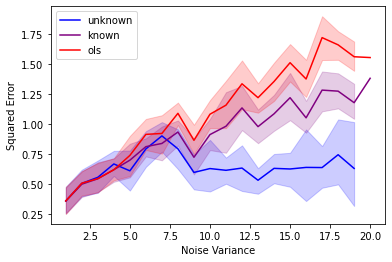

In [45]:
# plot results for regression parameter MSE
sns.lineplot(data=unknown, x='var', y='unknown_param_mse', label='unknown', color='blue')
sns.lineplot(data=known, x='var', y='known_param_mse', label='known', color='purple')
ax = sns.lineplot(data=ols, x='var', y='ols_param_mse', label='ols', color='red')
ax.set(xlabel='Noise Variance', ylabel='Squared Error')
plt.show()